# Multi-armed bandits (MAB) implementation

In [1]:
# Do not edit. These are the only imports permitted.
%matplotlib inline
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

In [41]:
import pandas as pd

## 1. Implementing ε-Greedy and UCB

In [65]:
class MAB(ABC):
    """
    Abstract class that represents a multi-armed bandit (MAB)
    """
    
    @abstractmethod
    def play(self, tround, context):
        """
        Play a round
        
        Arguments
        =========
        tround : int
            positive integer identifying the round
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to the arms
        
        Returns
        =======
        arm : int
            the positive integer arm id for this round
        """
    
    @abstractmethod
    def update(self, arm, reward, context):
        """
        Updates the internal state of the MAB after a play
        
        Arguments
        =========
        arm : int
            a positive integer arm id in {1, ..., self.narms}
        
        reward : float
            reward received from arm
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to arms
        """

## 3. Off-Policy Evaluation

In [67]:
def offlineEvaluate(mab, arms, rewards, contexts, nrounds=None):
    """
    Offline evaluation of a multi-armed bandit
    
    Arguments
    =========
    mab : instance of MAB
    
    arms : 1D int array, shape (nevents,) 
        integer arm id for each event
    
    rewards : 1D float array, shape (nevents,)
        reward received for each event
    
    contexts : 2D float array, shape (nevents, mab.narms*nfeatures)
        contexts presented to the arms (stacked horizontally) 
        for each event.
        
    nrounds : int, optional
        number of matching events to evaluate `mab` on.
    
    Returns
    =======
    out : 1D float array
        rewards for the matching events
    """
    
    # basic input checks to ensure everything works after assertions are passed
    assert isinstance(mab,MAB), 'MAB instance required'
    assert type(arms) is np.ndarray, 'arms should be numpy array'
    assert type(rewards) is np.ndarray, 'rewards should be numpy array'
    assert type(contexts) is np.ndarray, 'contexts should be numpy array'
    if nrounds is not None:
        assert type(nrounds) is int, 'input type int required for nrounds'
        assert nrounds > 0, 'nrounds should be greater than 0'
    assert 'int' in str(arms.dtype), 'arms should be int numpy array'
    assert 'float' in str(rewards.dtype), 'rewards should be float numpy array'
    assert 'float' in str(contexts.dtype), 'contexts should be float numpy array'
    assert arms.ndim == 1, 'arms should be 1D numpy array (nevents,) '
    assert rewards.ndim == 1, 'rewards should be 1D numpy array (nevents,)'
    assert contexts.ndim == 2, 'contexts should be 2D numpy array (nevents, mab.narms*nfeatures)'

    # initially empty history
    history = []
    
    # initially empty payoff
    out = []
    
    # get total number of events
    T = arms.shape[0]
    
    # ensuring there are events to evaluate
    assert T > 0, "There are no events for offline evaluation"
    
    # initilize control parameters
    events_parsed = 0
    all_events_parsed = False
    
    # sequentially parse stream of events
    for t in range(0,T):
        
        # repeat until matching arm is found
        while(True):
            
            # if all events are parsed - stop processing
            if events_parsed == T:
                all_events_parsed = True
                break
            
            # Get next event    
            # get selected arm
            a = arms[events_parsed]
            # get observed payoff for the arm
            r_a = rewards[events_parsed]
            # get observed context for the arm
            context = contexts[events_parsed,:]
            
            # keeping track of parsed events
            events_parsed += 1
     
            # set required round on the basis of history recorded
            tround = len(history)+1
            # play arm for tround
            arm = mab.play(tround,context)
            
            # check if arm is matched or not
            if arm == a:
                # matching arm found - update played arm
                mab.update(arm,r_a,context)
                break 
        
        # check if all events are parsed       
        if all_events_parsed:
            # stop processing
            break
            
        # record event tuple in history for each matched round
        event = (tround,a,r_a,context)
        history.append(event)      
        
        # add observed payoff for the matched arm
        out.append(r_a)
        
        # check if required rounds are reached, if provided
        if nrounds is not None and len(history) == nrounds:
            break
    
    # return per round rewards recorded
    return out

In [68]:
# loading dataset
dataset = np.loadtxt("dataset.txt")

# get arms from dataset
arms = dataset[:,0].astype('int')
# get rewards from dataset
rewards = dataset[:,1].astype('float')
# get contexts from dataset 
contexts = dataset[:,2:].astype('float')

In [69]:
arms[20]

8

In [70]:
arms[1]

8

In [71]:
contexts[20]

array([ 0.,  0.,  0.,  0.,  0., 80.,  0.,  0.,  0.,  0.,  0., 16.,  0.,
        0.,  0., 37.,  0.,  0.,  1.,  5.,  0.,  1.,  3.,  0.,  0.,  0.,
        0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  0.,
        0.,  0.,  6.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  4., 27., 32.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2., 24.,  0.,  7.,  0.,
        0.,  0.,  0.,  5.,  2.,  1.,  0.,  0.,  3.,  0.,  1.,  0.,  0.,
        0.,  0.,  5.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
        2.,  3.,  1.,  0.,  0.,  0.,  3., 15.,  5.])

In [72]:
contexts

array([[ 5.,  0.,  0., ..., 30.,  4.,  0.],
       [ 1.,  3., 36., ...,  0.,  0., 10.],
       [ 3.,  0.,  0., ...,  3.,  0.,  0.],
       ...,
       [79.,  0.,  0., ...,  0.,  0.,  0.],
       [29.,  0.,  2., ..., 17.,  0.,  0.],
       [ 0.,  2., 35., ...,  0.,  0., 12.]])

In [73]:
context = pd.DataFrame(contexts)

In [74]:
list(context.sort_values(by=0)[0])[-1000:]

[67.0,
 67.0,
 67.0,
 67.0,
 67.0,
 67.0,
 68.0,
 68.0,
 68.0,
 68.0,
 68.0,
 68.0,
 68.0,
 68.0,
 68.0,
 68.0,
 68.0,
 68.0,
 68.0,
 68.0,
 68.0,
 68.0,
 68.0,
 68.0,
 68.0,
 68.0,
 68.0,
 68.0,
 68.0,
 68.0,
 68.0,
 68.0,
 68.0,
 68.0,
 68.0,
 68.0,
 68.0,
 68.0,
 68.0,
 68.0,
 68.0,
 68.0,
 68.0,
 68.0,
 68.0,
 68.0,
 68.0,
 68.0,
 68.0,
 68.0,
 68.0,
 68.0,
 68.0,
 68.0,
 68.0,
 68.0,
 68.0,
 68.0,
 68.0,
 68.0,
 68.0,
 68.0,
 68.0,
 68.0,
 68.0,
 68.0,
 68.0,
 68.0,
 68.0,
 68.0,
 68.0,
 69.0,
 69.0,
 69.0,
 69.0,
 69.0,
 69.0,
 69.0,
 69.0,
 69.0,
 69.0,
 69.0,
 69.0,
 69.0,
 69.0,
 69.0,
 69.0,
 69.0,
 69.0,
 69.0,
 69.0,
 69.0,
 69.0,
 69.0,
 69.0,
 69.0,
 69.0,
 69.0,
 69.0,
 69.0,
 69.0,
 69.0,
 69.0,
 69.0,
 69.0,
 69.0,
 69.0,
 69.0,
 69.0,
 69.0,
 69.0,
 69.0,
 69.0,
 69.0,
 69.0,
 69.0,
 69.0,
 69.0,
 69.0,
 69.0,
 69.0,
 69.0,
 69.0,
 69.0,
 69.0,
 69.0,
 69.0,
 69.0,
 69.0,
 69.0,
 69.0,
 69.0,
 69.0,
 69.0,
 69.0,
 69.0,
 69.0,
 69.0,
 69.0,
 69.0,
 69.0,
 69.0,
 69.0,

## 5. Contextual Bandits - LinThompson

In [75]:
class LinThompson(MAB):
    """
    Contextual Thompson sampled multi-armed bandit (LinThompson)

    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    v : float
        positive real explore-exploit parameter
    """
    
    def __init__(self, narms, ndims, v):
      
        # basic input checks
        assert type(narms) is int, 'input type int required for narms'
        assert type(ndims) is int, 'input type int required for ndims'
        assert type(v) is float, 'input type float required for v'
        assert narms > 0, "number of arms should be greater than 0"
        assert ndims > 0, "ndims should be greater than 0"
        assert v > 0, "v should be greater than 0"
        
        # initilize MAB parameters
        self.narms = narms
        self.ndims = ndims
        self.v = v
        
        # initilize MAB state
        self.B = np.identity(ndims)        # ndims x ndims
        self.mu_hat = np.zeros((ndims,1))  # ndims x 1
        self.f = np.zeros((ndims,1))       # ndims x 1
        
    def play(self, tround, context):
        # initilize play parameters
        bounds = [0] * self.narms
        
        # generate samples from multivariate normal distribution 
        mean = np.transpose(self.mu_hat)[0]
        covariance_matrix = ((self.v)**2)*np.linalg.inv(self.B)
        # setting seed to reproduce results reliably
        np.random.seed(50005) # [bug] seed sometimes unreliable for multivariate normal
        samples = np.random.multivariate_normal(mean, covariance_matrix)
        # (ndims x 1) samples
        sample_mu_tilde = np.expand_dims(samples,axis=1)
        
        # perform operation for all arms
        for arm in range(0,self.narms):
            
            # get context for the arm (ndims x 1)
            arm_context = np.expand_dims(np.transpose(context[(arm*10):(arm*10)+10]),axis=1)
            
            # calculate value for the arm
            bounds[arm] = np.dot(np.transpose(arm_context),sample_mu_tilde)
            
        # get value-maximising arm from generated bounds
        maximum_arm_value = np.max(bounds)
            
        # handle tie-breaking using uniformly-at-random selection
        # setting seed to reproduce results reliably
        np.random.seed(50005)
        arm_to_play = np.random.choice(np.where(bounds==maximum_arm_value)[0],1)[0]
            
        # returning an arm integer in {1,...,self.narms}
        return arm_to_play+1
    
    def update(self, arm, reward, context):
        # update played arm
        
        # verifying arm input
        assert arm <= self.narms, "arm is larger than property narms"
        
        # Getting arm index
        arm_idx = arm-1
        
        # get context for the played arm
        arm_context = np.expand_dims(np.transpose(context[(arm_idx*10):(arm_idx*10)+10]),axis=1)
        
        # update state of the played arm
        self.B = self.B + np.dot(arm_context,np.transpose(arm_context))
        self.f = self.f + arm_context*reward
        self.mu_hat = np.dot(inv(self.B),self.f)

In [76]:
mab = LinThompson(10, 10, 1.0)
results_LinThompson = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinThompson average reward', np.mean(results_LinThompson))

LinThompson average reward 0.35625


In [115]:
narms = 2
ndims = 4
v=1.0

In [116]:
B = np.identity(ndims)        # ndims x ndims
mu_hat = np.zeros((ndims,1))  # ndims x 1
f = np.zeros((ndims,1))  

In [117]:
bounds = [0] * narms

In [118]:
mean = np.transpose(mu_hat)[0]
covariance_matrix = ((v)**2)*np.linalg.inv(B)

In [119]:
samples = np.random.multivariate_normal(mean, covariance_matrix)
# (ndims x 1) samples
sample_mu_tilde = np.expand_dims(samples,axis=1)

In [120]:
T=arms.shape[0]
history = []
    
    # initially empty payoff
out = []
nrounds=100

In [121]:
    events_parsed = 0
    all_events_parsed = False
    
    # sequentially parse stream of events
    for t in range(0,T):
        
        # repeat until matching arm is found
        while(True):
            
            # if all events are parsed - stop processing
            if events_parsed == T:
                all_events_parsed = True
                break
            
            # Get next event    
            # get selected arm
            a = arms[events_parsed]
            # get observed payoff for the arm
            r_a = rewards[events_parsed]
            # get observed context for the arm
            context = contexts[events_parsed,:]
            
            # keeping track of parsed events
            events_parsed += 1
     
            # set required round on the basis of history recorded
            tround = len(history)+1
            # play arm for tround
            arm = mab.play(tround,context)
            
            # check if arm is matched or not
            if arm == a:
                # matching arm found - update played arm
                mab.update(arm,r_a,context)
                break 
        
        # check if all events are parsed       
        if all_events_parsed:
            # stop processing
            break
            
        # record event tuple in history for each matched round
        event = (tround,a,r_a,context)
        history.append(event)      
        
        # add observed payoff for the matched arm
        out.append(r_a)
        
        # check if required rounds are reached, if provided
        if nrounds is not None and len(history) == nrounds:
            break

In [122]:
context

array([16.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  0.,  0.,
        0.,  0.,  0.,  0.,  7.,  0.,  0.,  5.,  9.,  0.,  0.,  0.,  0.,
        0., 27., 22.,  0.,  1.,  3.,  4.,  0.,  0.,  2.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0., 12., 25.,  0.,  0.,  0.,  9.,  0.,
        0.,  4.,  0.,  5.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  5.,  0.,  0.,  0.,
        0., 82.,  4.,  0.,  0.,  0.,  0.,  2.,  3.,  0.,  6.,  0.,  0.,
        0.,  0.,  0., 17.,  0., 21.,  1.,  0.,  0.])

In [131]:
for arm in range(0,narms):
            
            # get context for the arm (ndims x 1)
            arm_context = np.expand_dims(np.transpose(context[(arm*ndims):(arm*ndims)+ndims]),axis=1)
            
            # calculate value for the arm
            bounds[arm] = np.dot(np.transpose(arm_context),sample_mu_tilde)

In [132]:
arm_context

array([[0.],
       [0.],
       [0.],
       [0.]])

In [133]:
bounds

[array([[9.1495356]]), array([[0.]])]

In [134]:
contexts

array([[ 5.,  0.,  0., ..., 30.,  4.,  0.],
       [ 1.,  3., 36., ...,  0.,  0., 10.],
       [ 3.,  0.,  0., ...,  3.,  0.,  0.],
       ...,
       [79.,  0.,  0., ...,  0.,  0.,  0.],
       [29.,  0.,  2., ..., 17.,  0.,  0.],
       [ 0.,  2., 35., ...,  0.,  0., 12.]])

## 6. Evaluation
### 6.A.

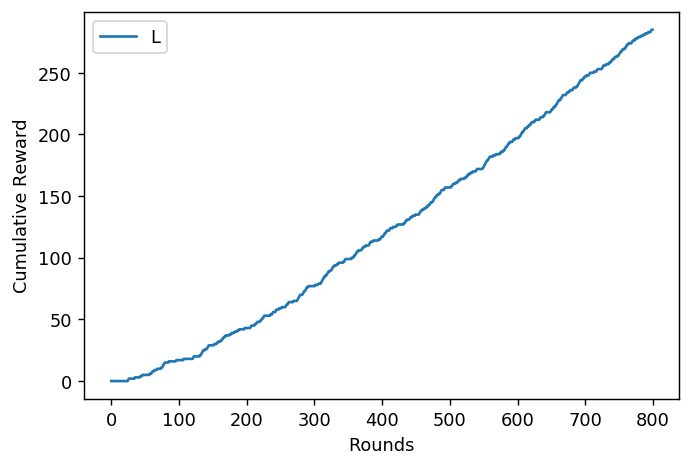

In [25]:
# setting figure parameters
FIGURE_RESOLUTION = 128
plt.rcParams['figure.dpi'] = FIGURE_RESOLUTION

# Evaluation function for plot

def evaluation(T, params):
    # initilize evaluation parameter
    linThompson_cumulative = [0] * T
    
    # LinThompson
    mab = LinThompson(10, 10, params['lin_thompson'])
    results_LinThompson = offlineEvaluate(mab, arms, rewards, contexts, T)

    # Get cumulative reward per round
    for t in range(1,T):
        linThompson_cumulative[t] = linThompson_cumulative[t-1] + results_LinThompson[t-1]

    # plot cumulative reward for algorithms
    t = np.arange(T)
    plt.plot(t, linThompson_cumulative)
    plt.legend('LinThompson', loc='upper left')
    plt.xlabel('Rounds')
    plt.ylabel('Cumulative Reward')
    plt.show()
    
# Evaluating algorithms for 800 rounds with provided hyperparameters
evaluation(T=800,params={'lin_thompson':1.0})

### 6.B.

In order to optimise hyperparameters, `GridSearchMAB` class is implemented which can take any of the above `MAB` based classes with 1 hyperparameter. So, this class will not support `BetaThompson` directly, but it can be enhanced easily.

`GridSearchMAB` is included with `strategy` parameter which can be used to include any grid-search strategy that is compatible with our MAB classes. Currently, it is implemented with basic naive grid-search strategy to find the most optimised hyperparameter:

- `Naive strategy`: In this strategy, `GridSearchMAB` will initilize `MAB` class with provided grid parameters which includes a range for target hyperparameter. We can then evaluate parameters provided in the range sequentially on the scoring function by keeping track of the results and corresponding mean score. Finally, we can get the best parameter from the range based on the maximum mean score.

This strategy is implemented in the class below, followed by results of LinUCB and LinThompson.

In [56]:
class GridSearchMAB:
  
    def __init__(self, mab, param_grid, scoring, strategy='naive', verbose=0):
        # initilize gridsearch parameters
        self.mab = mab
        self.param_grid = param_grid
        self.scoring = scoring
        self.verbose = verbose
        self.strategy = strategy
        
        # initilize gridsearch state
        self.results_ = {'mean_score':[],'evaluate_results':[],'params':[]}
        self.best_param_ = None
        self.best_score_ = None
      
    def fit(self,arms,rewards,contexts=None):
        # fit data on the basis of provided strategy
        if self.strategy == 'naive':
            self.naive_strategy(arms,rewards,contexts)
           
    def naive_strategy(self,arms,rewards,contexts=None):
        # get provided parameters
        prange = self.param_grid['param_range']
        narms = self.param_grid['narms']
        ndims = self.param_grid['ndims']
        rounds = self.param_grid['rounds']
        for param in prange:
            
            # making it compatible with other MABs (except BetaThompson)
            if ndims is not None:
                mabobj = self.mab(narms,ndims,float(param))
            else:
                mabobj = self.mab(narms,float(param))
            
            # evaluate mab on provided scoring function
            result = self.scoring(mabobj, arms, rewards, contexts, rounds)
            
            # store results in state
            self.results_['params'].append(param)
            self.results_['evaluate_results'].append(result)
            mean_score = np.mean(result)
            self.results_['mean_score'].append(mean_score)
            
            # message printing if required
            if self.verbose == 1:
              print('param: '+str(param)+' mean_score: '+str(mean_score))
        
        # get best parameter and score
        np_score = np.array(self.results_['mean_score'])
        self.best_score_ = np.max(np_score)
        self.best_param_ = float(prange[np.argmax(np_score)])

In [57]:
# Naive GridSearch strategy with LinUCB to find alpha

# generate 20 numbers for alpha between 10^-5 to 10^1
alphas = np.logspace(-5,1,20)

# set grid parameters with alphas
grid_parameters = {'narms': 10, 'ndims': 10, 'param_range': alphas,'rounds': 800}

# create gridsearch object with strategy and scoring function
grid_linucb = GridSearchMAB(mab=LinUCB, param_grid=grid_parameters, scoring=offlineEvaluate, strategy='naive',verbose=1)

# run gridsearch on provided data
grid_linucb.fit(arms,rewards,contexts)

# best alpha for LinUCB
print("\nThe best parameter is {0.best_param_:.4g} with a score of {0.best_score_:.4g}".format(grid_linucb))

param: 1e-05 mean_score: 0.64625
param: 2.06913808111479e-05 mean_score: 0.68
param: 4.281332398719396e-05 mean_score: 0.65625
param: 8.858667904100833e-05 mean_score: 0.67
param: 0.00018329807108324357 mean_score: 0.665
param: 0.000379269019073225 mean_score: 0.69625
param: 0.0007847599703514606 mean_score: 0.71375
param: 0.001623776739188721 mean_score: 0.7225
param: 0.003359818286283781 mean_score: 0.72875
param: 0.0069519279617756054 mean_score: 0.655
param: 0.01438449888287663 mean_score: 0.74125
param: 0.029763514416313162 mean_score: 0.715
param: 0.06158482110660261 mean_score: 0.7075
param: 0.1274274985703132 mean_score: 0.68625
param: 0.26366508987303555 mean_score: 0.64625
param: 0.5455594781168515 mean_score: 0.6175
param: 1.1288378916846884 mean_score: 0.4875
param: 2.3357214690901213 mean_score: 0.3075
param: 4.832930238571752 mean_score: 0.1875
param: 10.0 mean_score: 0.1225

The best parameter is 0.01438 with a score of 0.7412


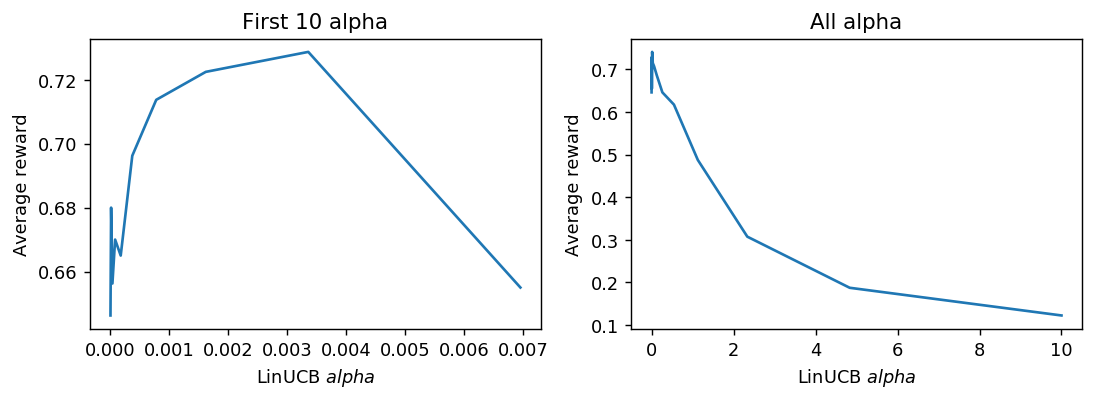

In [58]:
# plotting gridsearch results
fig, ax = plt.subplots(1, 2, figsize=(10,3), squeeze=False)
plt.subplot(1,2,1)
plt.plot(grid_linucb.results_['params'][0:10],grid_linucb.results_['mean_score'][0:10])
plt.title('First 10 alpha')
plt.xlabel('LinUCB $alpha$')
plt.ylabel('Average reward')
plt.subplot(1,2,2)
plt.plot(grid_linucb.results_['params'],grid_linucb.results_['mean_score'])
plt.title('All alpha')
plt.xlabel('LinUCB $alpha$')
plt.ylabel('Average reward')
plt.show()

Similarly, we can perform gridsearch for LinThompson using same `GridSearchMAB` class.

In [59]:
# Naive GridSearch strategy with LinThompson to find hyperparameter v

# generate 20 numbers for alpha between 10^-5 to 10^1
vparams = np.logspace(-5,1,20)

# set grid parameters with alphas
grid_parameters = {'narms': 10, 'ndims': 10, 'param_range': vparams,'rounds': 800}

# create gridsearch object with strategy and scoring function
grid_linthompson = GridSearchMAB(mab=LinThompson, param_grid=grid_parameters, scoring=offlineEvaluate, strategy='naive',verbose=1)

# run gridsearch on provided data
grid_linthompson.fit(arms,rewards,contexts)

# best v for LinThompson
print("\nThe best parameter is {0.best_param_:.4g} with a score of {0.best_score_:.4g}".format(grid_linthompson))

param: 1e-05 mean_score: 0.45625
param: 2.06913808111479e-05 mean_score: 0.44375
param: 4.281332398719396e-05 mean_score: 0.4325
param: 8.858667904100833e-05 mean_score: 0.43125
param: 0.00018329807108324357 mean_score: 0.42125
param: 0.000379269019073225 mean_score: 0.44875
param: 0.0007847599703514606 mean_score: 0.44
param: 0.001623776739188721 mean_score: 0.42875
param: 0.003359818286283781 mean_score: 0.425
param: 0.0069519279617756054 mean_score: 0.415
param: 0.01438449888287663 mean_score: 0.43375
param: 0.029763514416313162 mean_score: 0.41875
param: 0.06158482110660261 mean_score: 0.41375
param: 0.1274274985703132 mean_score: 0.435
param: 0.26366508987303555 mean_score: 0.48625
param: 0.5455594781168515 mean_score: 0.37125
param: 1.1288378916846884 mean_score: 0.30125
param: 2.3357214690901213 mean_score: 0.26125
param: 4.832930238571752 mean_score: 0.09
param: 10.0 mean_score: 0.2075

The best parameter is 0.2637 with a score of 0.4863


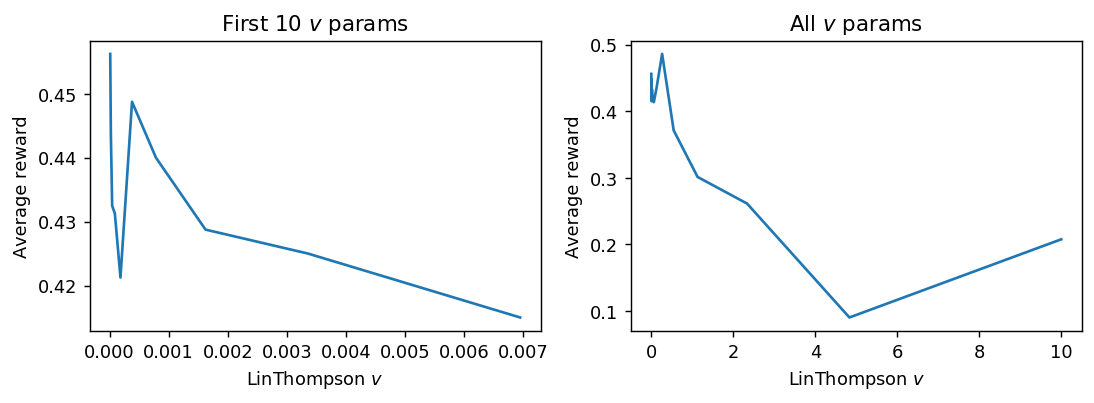

In [60]:
# plotting gridsearch results
fig, ax = plt.subplots(1, 2, figsize=(10,3), squeeze=False)
plt.subplot(1,2,1)
plt.plot(grid_linthompson.results_['params'][0:10],grid_linthompson.results_['mean_score'][0:10])
plt.title('First 10 $v$ params')
plt.xlabel('LinThompson $v$')
plt.ylabel('Average reward')
plt.subplot(1,2,2)
plt.plot(grid_linthompson.results_['params'],grid_linthompson.results_['mean_score'])
plt.title('All $v$ params')
plt.xlabel('LinThompson $v$')
plt.ylabel('Average reward')
plt.show()

Moreover, this class is flexible enough to run GridSearch strategies to find the most optimised hyperparameter for Epsilon Greedy and UCB MAB implementations. It can be enhanced easily to support MAB algorithms with more than 1 hyperparameter.

In [61]:
# Gridsearch for UCB
rhos = np.logspace(-5,1,20)
param_grid = {'narms': 10, 'ndims': None, 'param_range': rhos, 'rounds': 800}
grid_ucb = GridSearchMAB(UCB, param_grid, offlineEvaluate, strategy='naive', verbose=0)
grid_ucb.fit(arms,rewards,contexts)
print("The best parameter is {0.best_param_:.4g} with a score of {0.best_score_:.4g}".format(grid_ucb))

The best parameter is 0.02976 with a score of 0.2625


In [62]:
# Gridsearch for EpsGreedy
eps = np.logspace(-5,0,20)
param_grid = {'narms': 10, 'ndims': None, 'param_range': eps, 'rounds': 800}
grid_epsgreedy = GridSearchMAB(EpsGreedy, param_grid, offlineEvaluate, strategy='naive', verbose=0)
grid_epsgreedy.fit(arms,rewards,contexts)
print("The best parameter is {0.best_param_:.4g} with a score of {0.best_score_:.4g}".format(grid_epsgreedy))

The best parameter is 0.1624 with a score of 0.1462


Finally, we can plot the evaluation again with the optimised hyperparameters for each algorithm as shown below

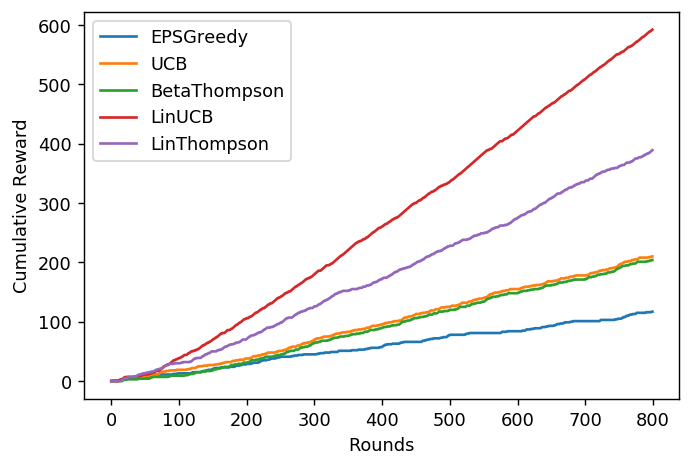

In [63]:
# Evaluating algorithms for 800 rounds with optimised hyperparameters
evaluation(T=800,params={'eps_greedy':grid_epsgreedy.best_param_, 'ucb':grid_ucb.best_param_, 'beta_thompson':[1.0,1.0], 'lin_ucb':grid_linucb.best_param_, 'lin_thompson':grid_linthompson.best_param_})